# Homework 7
## Astro 530 - Stellar Atmospheres

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy import units as u
from astropy import constants as c

from astro530 import partition

In [2]:
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 11

### 14. Saha's $\Phi\, (T)$

In [3]:
u_table = pd.read_table('./data/RepairedPartitionFunctions.txt', header=None, na_values='-', delim_whitespace=True)
u_table = u_table.set_index(0)

In [4]:
i_table = pd.read_table('./data/nist_ioniz.txt', header=None , delim_whitespace= True)
i_table = i_table.set_index(1)

In [5]:
def saha_phi(element, T, table = i_table):
    if element == 'H-':
        u0 = partition('H-', T, u_table)
        u1 = partition('H', T, u_table)
        I = 0.754 * u.eV
    else:
        u0 = partition(element, T, u_table)
        u1 = partition(element + '+', T, u_table)
        I = table.loc[element][3] * u.eV
        
    T *= u.K
    phi = (2 * np.pi * c.m_e)**(3/2) * (c.k_B * T)**(5/2) / c.h**3 * 2 * u1 / u0 * np.exp(-I/(c.k_B * T))
    return phi.to(u.barye)

### 15. Continuous Opacity

In [23]:
def chi(n, I):
    return I * (1 - 1/n**2)

def g_bf(l, n):
    limit = np.array([912, 3746, 8206, 14588]) * u.AA
    g = 1 - 0.3456 / (l * c.Ryd)**(1/3) * (l * c.Ryd / n**2 - 1/2)
    if n <= 4:
        ion_lim = np.where(l >= limit[n - 1])[0]
        g[ion_lim] = 0
    return g

def g_ff(l, T):
    g = 1 + 0.3456 / (l * c.Ryd)**(1/3) * (l * c.k_B * T / (c.h * c.c) + 1/2)
    return g


def KH_bf(l, T, table = i_table):

    l = l.to(u.AA).value
    theta = 5040 * u.K / T 
    a0 = 1.0449e-26
    loge = 0.43429
    I = table.loc['H'][3]
    
    sum_terms = np.array([g_bf(l * u.AA, n)/n**3 * 10 ** (-chi(n, I) * theta) for n in range(1, 5)]) 

    K = a0 * l**3 * (np.sum(sum_terms, axis = 0) + loge/(2 * theta * I) * (10**(-chi(5, I) * theta) - 10**(-I * theta)))
    return K * u.cm **2

def KH_ff(l, T, table = i_table):

    l = l.to(u.AA).value
    theta = 5040 * u.K / T 
    a0 = 1.0449e-26
    loge = 0.43429
    I = table.loc['H'][3]
    
    K = a0 * l**3 * g_ff(l * u.AA, T) * loge/(2 * theta * I) * 10**(-theta * I)
    return K * u.cm **2

def KHminus_bf(l, T, Pe):

    l = l.to(u.AA).value
    Pe = Pe.cgs.value
    theta = 5040 * u.K / T 
    
    a = np.array([1.99654, -1.18267e-5, 2.64243e-6, -4.40524e-10, 3.23992e-14, -1.39568e-18, 2.78701e-23])
    a_bf = np.sum([a[n] * l ** n for n in range(7)], axis = 0) * 10 ** -18
    
    K = 4.158e-10 * a_bf * Pe * theta**(5/2) * 10**(0.754 * theta)
    ion_lim = np.where(l * u.AA >= c.h *c.c/ (0.754 * u.eV))[0]
    K[ion_lim] = 0
    return K * u.cm **2

def KHminus_ff(l, T, Pe):

    l = l.to(u.AA).value
    Pe = Pe.cgs.value
    theta = 5040 * u.K / T 
    
    f0 = -2.2763 - 1.6850 * np.log10(l) + 0.76661 * np.log10(l)**2 - 0.053346 * np.log10(l)**3
    f1 = 15.2827 - 9.2846 * np.log10(l) + 1.99381 * np.log10(l)**2 - 0.142631 * np.log10(l)**3
    f2 = -197.789 + 190.266 * np.log10(l) - 67.9775 * np.log10(l)**2 + 10.6913 * np.log10(l)**3 - 0.625151 * np.log10(l)**4
    
    K = 1e-26 * Pe * 10**(f0 + f1 * np.log10(theta) + f2 * np.log10(theta)**2)
    return K * u.cm **2

In [24]:
def K_total(l, T, Pe):
    return (KH_bf(l, T) + KH_ff(l, T) + KHminus_bf(l, T, Pe)) * (1 - np.exp(-c.h * c.c / (l * c.k_B * T))) + KHminus_ff(l, T, Pe) 

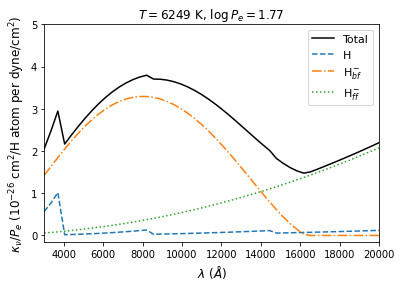

In [27]:
waveln = np.linspace(3000, 20000) * u.AA
T = 6429 * u.K
Pe = 10 ** 1.77 * u.barye

H_bf = KH_bf(waveln, T)
H_ff = KH_ff(waveln, T)
H = (KH_bf(waveln, T) + KH_ff(waveln, T)) / Pe
Hminus_bf = KHminus_bf(waveln, T, Pe) / Pe
Hminus_ff = KHminus_ff(waveln, T, Pe) / Pe
total = K_total(waveln, T, Pe) / Pe

plt.plot(waveln, total * 1e26, 'k-', lw=1.5, label = 'Total')
plt.plot(waveln, H * (1 - np.exp(-c.h * c.c / (waveln * c.k_B * T))) * 1e26, ls ='--', label= 'H')
plt.plot(waveln, Hminus_bf * (1 - np.exp(-c.h * c.c / (waveln * c.k_B * T))) * 1e26, ls = '-.', label= 'H$^-_{bf}$')
plt.plot(waveln, Hminus_ff * 1e26, ls = ':', label= 'H$^-_{ff}$')
plt.legend()

plt.ylim(-0.15, 5)

plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel(r'$\kappa_\nu / P_e$ ($10^{-26}$ cm$^2$/H atom per dyne/cm$^2$)')
plt.title(r'$T = 6249$ K, $\log P_e = 1.77$')

plt.savefig('fig8.5.b.png', bbox_inches = 'tight')
plt.show()

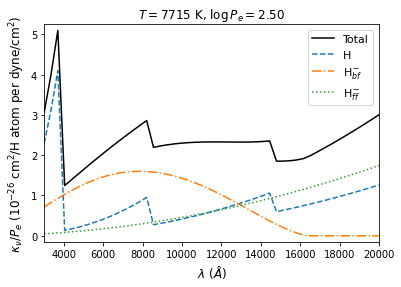

In [9]:
T = 7715 * u.K
Pe = 10 ** 2.50 * u.barye

H_bf = KH_bf(waveln, T)
H_ff = KH_ff(waveln, T)
H = (KH_bf(waveln, T) + KH_ff(waveln, T)) / Pe
Hminus_bf = KHminus_bf(waveln, T, Pe) / Pe
Hminus_ff = KHminus_ff(waveln, T, Pe) / Pe
total = K_total(waveln, T, Pe) / Pe

plt.plot(waveln, total * 1e26, 'k-', lw=1.5, label = 'Total')
plt.plot(waveln, H * (1 - np.exp(-c.h * c.c / (waveln * c.k_B * T))) * 1e26, ls ='--', label= 'H')
plt.plot(waveln, Hminus_bf * (1 - np.exp(-c.h * c.c / (waveln * c.k_B * T))) * 1e26, ls = '-.', label= 'H$^-_{bf}$')
plt.plot(waveln, Hminus_ff * 1e26, ls = ':', label= 'H$^-_{ff}$')
plt.legend()

plt.ylim(-0.15, 5.25)

plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel(r'$\kappa_\nu / P_e$ ($10^{-26}$ cm$^2$/H atom per dyne/cm$^2$)')
plt.title(r'$T = 7715$ K, $\log P_e = 2.50$')

plt.savefig('fig8.5.c.png', bbox_inches = 'tight')
plt.show()

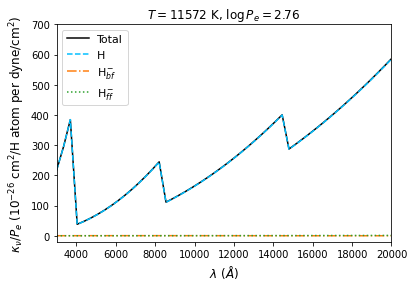

In [10]:
T = 11572 * u.K
Pe = 10 ** 2.76 * u.barye

H_bf = KH_bf(waveln, T)
H_ff = KH_ff(waveln, T)
H = (KH_bf(waveln, T) + KH_ff(waveln, T)) / Pe
Hminus_bf = KHminus_bf(waveln, T, Pe) / Pe
Hminus_ff = KHminus_ff(waveln, T, Pe) / Pe
total = K_total(waveln, T, Pe) / Pe

plt.plot(waveln, total * 1e26, 'k-', label = 'Total')
plt.plot(waveln, H * (1 - np.exp(-c.h * c.c / (waveln * c.k_B * T))) * 1e26, ls='--', color='deepskyblue', label= 'H')
plt.plot(waveln, Hminus_bf * (1 - np.exp(-c.h * c.c / (waveln * c.k_B * T))) * 1e26, 'C1-.', label= 'H$^-_{bf}$')
plt.plot(waveln, Hminus_ff * 1e26, 'C2:', label= 'H$^-_{ff}$')
plt.legend()

plt.ylim(-20, 700)

plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel(r'$\kappa_\nu / P_e$ ($10^{-26}$ cm$^2$/H atom per dyne/cm$^2$)')
plt.title(r'$T = 11572$ K, $\log P_e = 2.76$')

plt.savefig('fig8.5.d.png', bbox_inches = 'tight')
plt.show()